In [5]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from sys import argv
import ROOT
from ROOT import TH2F, TCanvas, TFile
import pandas as pd
from dataclasses import make_dataclass
import multiprocessing as mp

## Part 1, read log and get fit parameters and fit fraction

### Part 1-1, read log
Every bootstrapping sample do 10 random fits.\
Use func `read_logscan` to read the output of these fit results.\
Then use `pd.groupby` and `pd.merge` to get min NLL and its result index for each bootstrapping. \

In [6]:
def read_logscan(logfile):
    """This function is used to read logfiles generated by qnFit/sort.sh.
    To read the nll, file id and fit status into a dataframe.

    Args:
        logfile (_type_): _description_

    Returns:
        dataframe: _description_
    """
    # mass: bootstrapping file; id: fit result index; nll: NLL; status;
    one_log = make_dataclass("one_log", [("id", int), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[1].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(int(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1

In [3]:
# Use pd.groupby and pd.merge to get the id of minimum nll for each bootstrapping sample.
df1 = read_logscan("checklog.txt")
df1["state_undetailed"] = ""
df1["state"] = ""

df_converged = df1[df1["status"] == "CONVERGED"]
df_converged = df_converged.sort_values(by=["id"])
#df_converged[(df_converged["id"]>=0) & (df_converged["id"]<100)]["state"] = "f22150_mass_p"
list_state = [
    "f22150_mass_p",
    "f22150_mass_m",
    "f22150_width_p",
    "f22150_width_m",
    "f21950_mass_p",
    "f21950_mass_m",
    "f21950_width_p",
    "f21950_width_m",
    "Lc2860_mass_p",
    "Lc2860_mass_m",
    "Lc2860_width_p",
    "Lc2860_width_m",
    "Lc2880_mass_p",
    "Lc2880_mass_m",
    "Lc2880_width_p",
    "Lc2880_width_m",
    "Lc2940_mass_p",
    "Lc2940_mass_m",
    "Lc2940_width_p",
    "Lc2940_width_m",
    "rho2150_mass_p",
    "rho2150_mass_m",
    "rho2150_width_p",
    "rho2150_width_m",
    ]
list_state_undetailed = [
    "f22150_mass",
    "f22150_width",
    "f21950_mass",
    "f21950_width",
    "Lc2860_mass",
    "Lc2860_width",
    "Lc2880_mass",
    "Lc2880_width",
    "Lc2940_mass",
    "Lc2940_width",
    "rho2150_mass",
    "rho2150_width",
    ]
list_id = np.arange(0,2500,100).tolist()
for i in range(len(list_id)-1):
    df_converged.loc[(df_converged["id"]>=list_id[i]) & (df_converged["id"]<list_id[i+1]),"state"] = list_state[i]
list_id_undetailed = np.arange(0,2500,200).tolist()
for i in range(len(list_id_undetailed)-1):
    df_converged.loc[(df_converged["id"]>=list_id_undetailed[i]) & (df_converged["id"]<list_id_undetailed[i+1]),"state_undetailed"] = list_state_undetailed[i]
df_groupby = df_converged[["state","nll"]].groupby(by="state")["nll"].min()
df_merge = pd.merge(df_groupby,df_converged,how="left",on=["state","nll"])
#df_groupby = df_converged[["mass","nll"]].groupby(by="mass")["nll"].min()
#df_merge = pd.merge(df_groupby,df_converged,how="left",on=["mass","nll"])
#df_merge_firstid = df_merge.groupby(by="mass")["id"].min()
#df_merge = pd.merge(df_merge_firstid,df_merge,how="left",on=["mass","id"])
print(df_converged.head())
print(df_converged.shape)
print(df_merge.head())
print(df_merge.shape)
df_merge.to_csv("checklog_converged.csv",index=False)

     id      nll     status state_undetailed          state
2     2 -10448.3  CONVERGED      f22150_mass  f22150_mass_p
190   8 -11118.5  CONVERGED      f22150_mass  f22150_mass_p
201   9 -11085.7  CONVERGED      f22150_mass  f22150_mass_p
215  10 -11126.5  CONVERGED      f22150_mass  f22150_mass_p
235  11 -11127.9  CONVERGED      f22150_mass  f22150_mass_p
(1540, 5)
            state      nll    id     status state_undetailed
0   Lc2860_mass_m -11131.1   903  CONVERGED      Lc2860_mass
1   Lc2860_mass_p -11126.7   806  CONVERGED      Lc2860_mass
2  Lc2860_width_m -11126.9  1166  CONVERGED     Lc2860_width
3  Lc2860_width_p -11128.1  1065  CONVERGED     Lc2860_width
4   Lc2880_mass_m -11126.4  1369  CONVERGED      Lc2880_mass
(27, 5)


### Part 1-2, get fit parameters
The `df_merge` could give us the fit parameters file *.func we need.\
Then use the dataframe `df_temp` to load the *.func file.\
`pd.concat` join two dataframe together according to  the same column, which is really useful.

In [7]:
title = ["id","m0_2900","width_2900","m0_3130","width_3130","m0_3189","width_3189","width_NR0m"]
df_original = pd.DataFrame(columns=title)
df_original = df_original.append({"state_undetailed":-999,"state":-999,"id":-999,"m0_2900":-999,"m0_3130":-999,"m0_3189":-999,"width_2900":-999,"width_3130":-999,"width_3189":-999,"width_NR0m":-999},ignore_index=True)
for i in range(0,df_merge.shape[0]):
    temp_id = df_merge.iloc[i]["id"]
    if temp_id<100:
        continue
    temp_state = df_merge.iloc[i]["state"]
    temp_state_undetailed = df_merge.iloc[i]["state_undetailed"]
    temp_filename = "funcs/fit-"+str(temp_id)+".func"
    temp_file = open(temp_filename,"r+")
    dict_temp = {}
    for line1 in temp_file:
        dict_temp[line1.split()[0]] = line1.split()[2]
    dict_temp["id"] = temp_id
    dict_temp["state"] = temp_state
    dict_temp["state_undetailed"] = temp_state_undetailed
    df_temp = pd.DataFrame(dict_temp,index=[0])
    df_original = pd.concat([df_original,df_temp],join="inner")
df_original = df_original[df_original["id"]>=0]
print(df_original.head())
print(df_original.shape)
#df_original.to_csv("fit_result.csv",index=False)
#df_result = pd.read_csv("fit_result.csv")
#df_result = df_result.drop(["bootfile","id"],axis=1)
#print(df_result.describe())
#df_result.hist(layout=(3,3),sharex=False,sharey=False,figsize=(20,10),bins=20)
#plt.savefig("parameters.pdf")
df_original.to_csv("fit_result.csv",index=False)

     id m0_2900 width_2900 m0_3130 width_3130 m0_3189 width_3189  width_NR0m  \
0   903  2.8168   0.030719  3.2535    0.20136  2.9722    0.14422     0.96469   
0   806  2.8202   0.037142  3.2571    0.20025  2.9685    0.13483   -0.129436   
0  1166  2.8173   0.038222  3.2534    0.20546  2.9639    0.14023     0.98758   
0  1065  2.8195   0.039679  3.2622    0.20322  2.9683    0.12811  -0.0912225   
0  1369  2.8191   0.040356  3.2605    0.20408  2.9663    0.13380   -0.118347   

            state state_undetailed  
0   Lc2860_mass_m      Lc2860_mass  
0   Lc2860_mass_p      Lc2860_mass  
0  Lc2860_width_m     Lc2860_width  
0  Lc2860_width_p     Lc2860_width  
0   Lc2880_mass_m      Lc2880_mass  
(26, 10)


In [15]:
df_original = pd.read_csv("fit_result.csv")
#dict_realvalue = {"m0_2900":2.827,"width_2900":0.036,"m0_3130":3.252,"width_3130":0.211,"m0_3189":2.988,"width_3189":0.121}
dict_realvalue = {"m0_2900":2.817,"m0_3130":3.255,"m0_3189":2.969,"width_2900":0.037,"width_3130":0.206,"width_3189":0.138}
for key in dict_realvalue:
    df_original[key] = df_original[key].apply(lambda x: x-dict_realvalue[key])
df_original.drop(columns="state").groupby(by="state_undetailed").max()

id  m0_2900  width_2900  m0_3130  width_3130  m0_3189  \
state_undetailed                                                            
Lc2860_mass        903   0.0032    0.000142   0.0021    -0.00464   0.0032   
Lc2860_width      1166   0.0025    0.002679   0.0072    -0.00054  -0.0007   
Lc2880_mass       1369   0.0055    0.003356   0.0055    -0.00192   0.0000   
Lc2880_width      1578   0.0053    0.003159   0.0048    -0.00183  -0.0004   
Lc2940_mass       1702   0.0008    0.002738   0.0003     0.00232   0.0005   
Lc2940_width      1962   0.0017    0.005200   0.0054     0.00063   0.0005   
f21950_mass        524   0.0031    0.000794   0.0030    -0.00034   0.0026   
f21950_width       776   0.0048    0.002943   0.0035    -0.00375  -0.0015   
f22150_mass        177   0.0038    0.004287   0.0040    -0.00147  -0.0030   
f22150_width       315   0.0058    0.008248   0.0056    -0.00342  -0.0016   
rho2150_mass      2154   0.0037    0.002973   0.0069     0.00123   0.0029   
rho2150_width     2311   0.0008   -0.001205   0.0034    -0.00176   0.0072   

                  width_3189  width_NR0m  
state_undetailed                          
Lc2860_mass          0.00622    0.964690  
Lc2860_width         0.00223    0.987580  
Lc2880_mass         -0.00153   -0.118347  
Lc2880_width        -0.00148   -0.080065  
Lc2940_mass          0.00092    1.183800  
Lc2940_width        -0.00108   -0.029118  
f21950_mass          0.00280   -0.094426  
f21950_width        -0.00243   -0.138508  
f22150_mass         -0.00275   -0.144980  
f22150_width        -0.00410   -0.043528  
rho2150_mass        -0.00154   -0.105669  
rho2150_width        0.00391   -0.035036

In [16]:
df_original.drop(columns="state").groupby(by="state_undetailed").min()

id  m0_2900  width_2900  m0_3130  width_3130  m0_3189  \
state_undetailed                                                            
Lc2860_mass        806  -0.0002   -0.006281  -0.0015    -0.00575  -0.0005   
Lc2860_width      1065   0.0003    0.001222  -0.0016    -0.00278  -0.0051   
Lc2880_mass       1203   0.0021    0.002533   0.0040    -0.00340  -0.0027   
Lc2880_width      1470   0.0037    0.000702   0.0038    -0.00353  -0.0010   
Lc2940_mass       1616  -0.0002   -0.000362  -0.0010     0.00177  -0.0027   
Lc2940_width      1859   0.0000   -0.002341   0.0025    -0.00399  -0.0001   
f21950_mass        440   0.0009   -0.001310   0.0008    -0.00551  -0.0013   
f21950_width       633   0.0035    0.002659   0.0031    -0.00405  -0.0018   
f22150_mass        177   0.0038    0.004287   0.0040    -0.00147  -0.0030   
f22150_width       267   0.0014   -0.000707   0.0027    -0.00421  -0.0016   
rho2150_mass      2000   0.0022   -0.002171   0.0010    -0.00727  -0.0021   
rho2150_width     2260  -0.0009   -0.001445   0.0000    -0.00297  -0.0018   

                  width_3189  width_NR0m  
state_undetailed                          
Lc2860_mass         -0.00317   -0.129436  
Lc2860_width        -0.00989   -0.091222  
Lc2880_mass         -0.00420   -0.156855  
Lc2880_width        -0.00154   -0.113864  
Lc2940_mass         -0.00238    0.967110  
Lc2940_width        -0.00389   -0.079385  
f21950_mass         -0.00243   -0.132005  
f21950_width        -0.00299   -0.143356  
f22150_mass         -0.00275   -0.144980  
f22150_width        -0.00453   -0.086318  
rho2150_mass        -0.00542   -0.158719  
rho2150_width       -0.00361   -0.070263

In [18]:
df_original[df_original["state_undetailed"]=="Lc2860_mass"].drop(columns=["state","state_undetailed"])
lamb_maxAbs = lambda x: max(x.min(),x.max(),key=abs)
dict_temp = df_original[df_original["state_undetailed"]=="Lc2860_mass"].drop(columns=["state","state_undetailed"]).apply(lamb_maxAbs).to_dict()
dict_state_undetailed = {
    "f22150_mass":"$f_2(2150)$ mass",
    "f22150_width":"$f_2(2150)$ width",
    "f21950_mass":"$f_2(1950)$ mass",
    "f21950_width":"$f_2(1950)$ width",
    "Lc2860_mass":"$\qnLc{2860}$ mass",
    "Lc2860_width":"$\qnLc{2860}$ width",
    "Lc2880_mass":"$\qnLc{2880}$ mass",
    "Lc2880_width":"$\qnLc{2880}$ width",
    "Lc2940_mass":"$\qnLc{2940}$ mass",
    "Lc2940_width":"$\qnLc{2940}$ width",
    "rho2150_mass":"$\\rho(2150)$ mass",
    "rho2150_width":"$\\rho(2150)$ width",
}
for key,value in dict_state_undetailed.items():
#for i in range(1):
    dict_temp = df_original[df_original["state_undetailed"]==key].drop(columns=["state","state_undetailed","id","width_NR0m"]).apply(lamb_maxAbs).to_dict()
    print(value,end=" ")
    for key in dict_temp:
        print("&",end=" ")
        print("{0:.3f}".format(dict_temp[key]),end=" ")
    print("\\\\")

$f_2(2150)$ mass & 0.004 & 0.004 & 0.004 & -0.001 & -0.003 & -0.003 \\
$f_2(2150)$ width & 0.006 & 0.008 & 0.006 & -0.004 & -0.002 & -0.005 \\
$f_2(1950)$ mass & 0.003 & -0.001 & 0.003 & -0.006 & 0.003 & 0.003 \\
$f_2(1950)$ width & 0.005 & 0.003 & 0.004 & -0.004 & -0.002 & -0.003 \\
$\qnLc{2860}$ mass & 0.003 & -0.006 & 0.002 & -0.006 & 0.003 & 0.006 \\
$\qnLc{2860}$ width & 0.002 & 0.003 & 0.007 & -0.003 & -0.005 & -0.010 \\
$\qnLc{2880}$ mass & 0.005 & 0.003 & 0.006 & -0.003 & -0.003 & -0.004 \\
$\qnLc{2880}$ width & 0.005 & 0.003 & 0.005 & -0.004 & -0.001 & -0.002 \\
$\qnLc{2940}$ mass & 0.001 & 0.003 & -0.001 & 0.002 & -0.003 & -0.002 \\
$\qnLc{2940}$ width & 0.002 & 0.005 & 0.005 & -0.004 & 0.001 & -0.004 \\
$\rho(2150)$ mass & 0.004 & 0.003 & 0.007 & -0.007 & 0.003 & -0.005 \\
$\rho(2150)$ width & -0.001 & -0.001 & 0.003 & -0.003 & 0.007 & 0.004 \\


### Part 1-3, get fit fractions

In [19]:
def read_reverse_order(file_name):
    """Copied from website. Read a file from the end in a quick way

    Args:
        file_name (_type_): _description_

    Yields:
        _type_: _description_
    """
    # Open file for reading in binary mode
    with open(file_name, 'rb') as read_obj:
        # Move the cursor to the end of the file
        read_obj.seek(0, os.SEEK_END)
        # Get the current position of pointer i.e eof
        pointer_location = read_obj.tell()
        # Create a buffer to keep the last read line
        buffer = bytearray()
        # Loop till pointer reaches the top of the file
        while pointer_location >= 0:
            # Move the file pointer to the location pointed by pointer_location
            read_obj.seek(pointer_location)
            # Shift pointer location by -1
            pointer_location = pointer_location -1
            # read that byte / character
            new_byte = read_obj.read(1)
            # If the read byte is new line character then it means one line is read
            if new_byte == b'\n':
                # Fetch the line from buffer and yield it
                yield buffer.decode()[::-1]
                # Reinitialize the byte array to save next line
                buffer = bytearray()
            else:
                # If last read character is not eol then add it in buffer
                buffer.extend(new_byte)
        # As file is read completely, if there is still data in buffer, then its the first line.
        if len(buffer) > 0:
            # Yield the first line too
            yield buffer.decode()[::-1]

def read_FF(logfile_name):
    """Use function read_reverse_order to read the logfile from the end.
    Because the Fit Fractions is at the end of each log file.

    Args:
        logfile_name (_type_): _description_
    """
    i = 0
    temp_dict = {}
    for line in read_reverse_order(logfile_name):
        if(i>18):
            break
        if(i>5):
            #print({line.split()[0]:line.split()[1]})
            temp_dict[line.split()[0]] = line.split()[1]
            #print(line.split()[1])
            #print(line.split()[0])
        i = i+1
#    temp_dict["bootfile"] = logfile_name
    return temp_dict

In [20]:
df_FF = pd.DataFrame(read_FF("test.log"),index=[0])
df_FF["id"] = ""
df_FF["state"] = ""
df_FF["state_undetailed"] = ""
df_original = pd.read_csv("fit_result.csv")
df_original = df_original[["id","state","state_undetailed"]]
arr_original = df_original.values.tolist()
for i in range(len(arr_original)):
    temp_filename = "logs/fit-"+str(arr_original[i][0]).zfill(4)+".log"
    df_FF = df_FF.append(read_FF(temp_filename),ignore_index=True)
    df_FF["id"][i+1] = arr_original[i][0]
    df_FF["state"][i+1] = arr_original[i][1]
    df_FF["state_undetailed"][i+1] = arr_original[i][2]
df_FF = df_FF.drop([0])
print(df_FF.head())
print(df_FF.shape)
df_FF.to_csv("FF_result.csv",index=False)
df_FF_new = pd.read_csv("FF_result.csv") # export to csv and read it again can show the correct df.describe() result. so ridiculous.

    Total X_f2_2150 X_f2_1950 X_rho_2150 X_Fwave X_NR0m Y_L_2860 Y_L_2880  \
1  128.64      5.66      4.38       9.19   54.00   4.05     7.51     0.41   
2  128.62      5.96      4.71      11.95   53.83   2.38     7.45     0.36   
3  128.63      5.61      3.93       8.66   51.69   6.08     6.28     0.55   
4  128.46      5.45      4.94      12.23   53.69   3.25     9.35     0.33   
5  128.67      5.90      4.87      11.51   52.34   3.90     7.62     0.38   

  Y_L_2940 Y_L_2765 Y_L_2900 Y_L_3130 Y_L_3189    id           state  \
1     0.19     8.94     3.46    10.93    19.92   903   Lc2860_mass_m   
2     0.23    10.20     4.62    10.65    16.28   806   Lc2860_mass_p   
3     0.17     9.51     5.17    11.43    19.54  1166  Lc2860_width_m   
4     0.22    11.72     3.48    10.46    13.35  1065  Lc2860_width_p   
5     0.21     9.57     4.40    11.02    16.96  1369   Lc2880_mass_m   

  state_undetailed  
1      Lc2860_mass  
2      Lc2860_mass  
3     Lc2860_width  
4     Lc2860_width  

In [21]:
df_FF = pd.read_csv("FF_result.csv") 
df_FF_X = df_FF[["Total","X_f2_2150","X_f2_1950","X_rho_2150","X_Fwave","X_NR0m","state","state_undetailed","id"]]
df_FF_Y = df_FF[["Y_L_2860","Y_L_2880","Y_L_2940","Y_L_2765","Y_L_2900","Y_L_3130","Y_L_3189","state","state_undetailed","id"]]
dict_real_FF = {"Total":128.51,
                "X_f2_2150":5.79,
                "X_f2_1950":3.85,
                "X_rho_2150":9.21,
                "X_Fwave":52.61,
                "X_NR0m":4.40,
                "Y_L_2860":7.84,
                "Y_L_2880":0.43,
                "Y_L_2940":0.27,
                "Y_L_2765":9.85,
                "Y_L_2900":5.09,
                "Y_L_3130":11.37,
                "Y_L_3189":17.83,
                }
dict_real_FF_X = {
                "Total":128.51,
                "X_f2_2150":5.79,
                "X_f2_1950":3.85,
                "X_rho_2150":9.21,
                "X_Fwave":52.61,
                "X_NR0m":4.40,
}
dict_real_FF_Y = {
                "Y_L_2860":7.84,
                "Y_L_2880":0.43,
                "Y_L_2940":0.27,
                "Y_L_2765":9.85,
                "Y_L_2900":5.09,
                "Y_L_3130":11.37,
                "Y_L_3189":17.83,
                }
for key in dict_real_FF_X:
    df_FF_X[key] = df_FF_X[key].apply(lambda x: x-dict_real_FF_X[key])
lamb_maxAbs = lambda x: max(x.min(),x.max(),key=abs)
for key,value in dict_state_undetailed.items():
#for i in range(1):
    dict_temp = df_FF_X[df_FF_X["state_undetailed"]==key].drop(columns=["state","state_undetailed","id"]).apply(lamb_maxAbs).to_dict()
    print(value,end=" ")
    for key in dict_temp:
        print("&",end=" ")
        print("{0:.2f}".format(dict_temp[key]),end=" ")
    print("\\\\")
for key in dict_real_FF_Y:
    df_FF_Y[key] = df_FF_Y[key].apply(lambda x: x-dict_real_FF_Y[key])
lamb_maxAbs = lambda x: max(x.min(),x.max(),key=abs)

for key,value in dict_state_undetailed.items():
#for i in range(1):
    dict_temp = df_FF_Y[df_FF_Y["state_undetailed"]==key].drop(columns=["state","state_undetailed","id"]).apply(lamb_maxAbs).to_dict()
    print(value,end=" ")
    for key in dict_temp:
        print("&",end=" ")
        print("{0:.2f}".format(dict_temp[key]),end=" ")
    print("\\\\")

/tmp/qinning/ipykernel_21486/2049711681.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_FF_X[key] = df_FF_X[key].apply(lambda x: x-dict_real_FF_X[key])
/tmp/qinning/ipykernel_21486/2049711681.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_FF_Y[key] = df_FF_Y[key].apply(lambda x: x-dict_real_FF_Y[key])


$f_2(2150)$ mass & 0.13 & 0.22 & 1.10 & 2.57 & -0.18 & -0.76 \\
$f_2(2150)$ width & 0.16 & 1.09 & 1.20 & 2.41 & 2.15 & -1.30 \\
$f_2(1950)$ mass & 0.09 & 0.28 & 2.27 & 2.98 & 2.18 & -1.76 \\
$f_2(1950)$ width & 0.16 & 0.14 & 1.35 & 2.39 & -0.30 & -0.61 \\
$\qnLc{2860}$ mass & 0.13 & 0.17 & 0.86 & 2.74 & 1.39 & -2.02 \\
$\qnLc{2860}$ width & 0.12 & -0.34 & 1.09 & 3.02 & 1.08 & 1.68 \\
$\qnLc{2880}$ mass & 0.22 & 0.11 & 1.29 & 2.79 & 2.03 & -1.16 \\
$\qnLc{2880}$ width & 0.23 & 0.14 & 1.13 & 2.35 & -0.10 & -0.46 \\
$\qnLc{2940}$ mass & -2.30 & -0.10 & 0.40 & -2.25 & 1.09 & -1.98 \\
$\qnLc{2940}$ width & 0.14 & 0.20 & 1.29 & 2.08 & 1.41 & -2.51 \\
$\rho(2150)$ mass & 0.23 & 0.33 & 1.21 & 3.61 & 1.48 & -1.96 \\
$\rho(2150)$ width & 0.37 & 0.56 & 1.00 & 1.58 & 2.97 & -2.59 \\
$f_2(2150)$ mass & -0.68 & -0.08 & -0.08 & -0.03 & -0.79 & -0.34 & -0.84 \\
$f_2(2150)$ width & 0.45 & -0.07 & -0.05 & -0.43 & -1.02 & -0.64 & -2.24 \\
$f_2(1950)$ mass & -0.69 & -0.05 & -0.04 & 0.80 & -1.36 & -0.50 & 

## Part 2, calculate the asymmetrical error for fit fraction and parameters

In [8]:
def cal_asym_std(df_input, mean_input):
    if df_input.empty:
        return -999
    else:
        return sqrt(pow(df_input - mean_input,2).sum()/df_input.size)

def read_logfile(logfile):
    one_log = make_dataclass("one_log", [("id", str), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[1].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(str(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1

In [9]:
df_FF = pd.read_csv("FF_result.csv")
df_FF.describe()

#dict_FF_model0 = {"X_f2_2150":5.12, "X_rho_2150":9.36, "X_f2_1950":3.63, "X_NR0m":2.41, "X_Fwave":49.77, "Y_L_2765":8.51, "Y_L_2940":0.14, "Y_L_2860":4.07, "Y_L_2880":0.28, "Y_L_2900":4.22, "Y_L_3130":12.26, "Y_L_3189":13.40}
dict_FF_model0 = {"X_f2_2150":5.10, "X_rho_2150":9.21, "X_f2_1950":3.69, "X_NR0m":2.52, "X_Fwave":49.66, "Y_L_2765":3.94, "Y_L_2940":0.14, "Y_L_2860":4.12, "Y_L_2880":0.28, "Y_L_2900":4.23, "Y_L_3130":12.25, "Y_L_3189":13.41}

temp_name = "X_f2_2150"
df_FF_temp = df_FF[df_FF[temp_name] > dict_FF_model0[temp_name]]

list_up = []
list_lo = []
for key,value in dict_FF_model0.items():
    df_FF_up = df_FF[ df_FF[key] > value ][key]
    df_FF_lo = df_FF[ df_FF[key] < value ][key]
    list_up.append(cal_asym_std(df_FF_up, value))
    list_lo.append(cal_asym_std(df_FF_lo, value))

i=0
for key,value in dict_FF_model0.items():
    temp_FF = "$" + "{:.2f}".format(value) + "^{+" + "{:.2f}".format(list_up[i]) +"}" + "_{-" + "{:.2f}".format(list_lo[i]) +"}$ "
    line = "{:<15} & {:<30} \\\\".format(key, temp_FF)
    print(line)
    i = i+1

X_f2_2150       & $5.10^{+1.06}_{-0.66}$         \\
X_rho_2150      & $9.21^{+2.42}_{-1.40}$         \\
X_f2_1950       & $3.69^{+1.44}_{-0.86}$         \\
X_NR0m          & $2.52^{+4.57}_{-1.44}$         \\
X_Fwave         & $49.66^{+6.62}_{-6.72}$        \\
Y_L_2765        & $3.94^{+1.36}_{-0.63}$         \\
Y_L_2940        & $0.14^{+0.45}_{-0.07}$         \\
Y_L_2860        & $4.12^{+1.56}_{-0.98}$         \\
Y_L_2880        & $0.28^{+0.18}_{-0.10}$         \\
Y_L_2900        & $4.23^{+1.87}_{-1.41}$         \\
Y_L_3130        & $12.25^{+1.35}_{-1.47}$        \\
Y_L_3189        & $13.41^{+3.58}_{-3.58}$        \\


In [10]:
dict_FitParameters_model0 = {"m0_2900":2.827,"m0_3130":3.252,"m0_3189":2.988,"width_2900":0.036,"width_3130":0.211,"width_3189":0.121}
list_up_FP = []
list_lo_FP = []
for key,value in dict_FitParameters_model0.items():
    df_result_up = df_result[ df_result[key] > value ][key]
    df_result_lo = df_result[ df_result[key] < value ][key]
    list_up_FP.append(cal_asym_std(df_result_up, value))
    list_lo_FP.append(cal_asym_std(df_result_lo, value))
i=0
for key,value in dict_FitParameters_model0.items():
    temp_FF = "$" + str(value) + "^{+" + "{:.3f}".format(list_up_FP[i]) +"}" + "_{-" + "{:.3f}".format(list_lo_FP[i]) +"}$ "
    line = "{:<15} & {:<30} &".format(key, temp_FF)
    print(line)
    i = i+1

m0_2900         & $2.827^{+0.007}_{-0.009}$      &
m0_3130         & $3.252^{+0.010}_{-0.009}$      &
m0_3189         & $2.988^{+0.011}_{-0.012}$      &
width_2900      & $0.036^{+0.006}_{-0.008}$      &
width_3130      & $0.211^{+0.019}_{-0.019}$      &
width_3189      & $0.121^{+0.012}_{-0.013}$      &


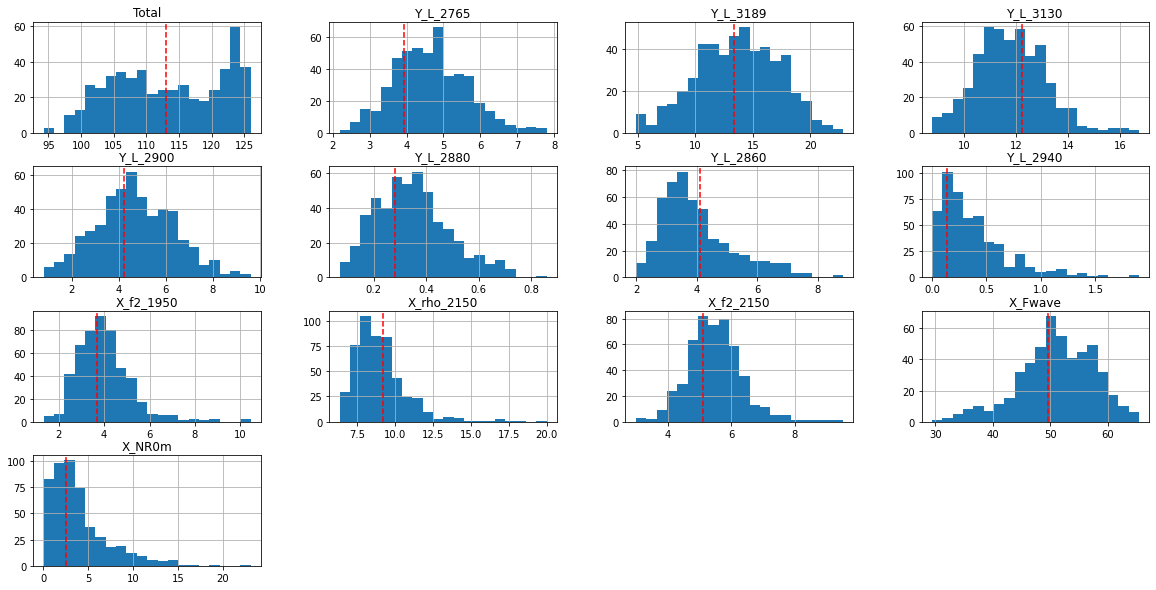

In [24]:
plots_FF=df_FF_new.hist(layout=(4,4),sharex=False,sharey=False,figsize=(20,10),bins=20)
for i in range(len(plots_FF)):
    for ax in plots_FF[i]:
        if ax.get_title() == "Total":
            temp_mean = 113
        elif ax.get_title() == "":
            continue
        else:
            temp_mean = dict_FF_model0[ax.get_title()]
        ax.axvline(x=temp_mean,color="red",linestyle="--")